# MT tip simulation 
Model tip fluctuations and their contributions in a 1D fashion

Including 'B-C model' suggesting 2 different states at tip (B, C), 
Ignoring the extra state "A" (as introduced in Maurer et al. 2014)

In [1]:
# Import packages
import sys
import os
import shutil
import pickle
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [3]:
# Initialize random number generator:
np.random.seed(42) #int(100*clock()))

# Import functions
import mtdynamics.simulation_functions as sFUNC #import simulation functions
import mtdynamics.simulation_parameters as simParameters #import simulation parameters
import mtdynamics.simulation_main as sMAIN #import main simulation function
import mtdynamics.plotting_functions as plotf #import plotting functions
from parameters import ParameterSet

growth speed set to:  1.8


### Load parameters from simulation_parameters.py

In [4]:
simPa = ParameterSet(simParameters.simParameters)

### Create folder based on date

In [5]:
# Read actual time + date
now = datetime.now()
date_time = now.strftime("%m-%d-%Y__%H-%M-%S")

# Create main folder to save data
PATH_RESULTS = os.path.join(ROOT, 'SIM_RUNS', date_time)

if not os.path.exists(os.path.join(ROOT, 'SIM_RUNS')):
    os.makedirs(os.path.join(ROOT, 'SIM_RUNS'))
if simPa.record_data == True:
    os.mkdir(PATH_RESULTS) # create (sub)folder    

### Inspect simulation parameters:

In [6]:
simPa

{'record_data': True,
 'record_data_full': False,
 'plot_figures': True,
 'compare_results': False,
 'end_hydrolysis': True,
 'frame_rate_aim': 0.25,
 'record_cap': False,
 'record_length': False,
 'steady_state_analysis': False,
 'EB': 0,
 'growth_speed': 1.8,
 'dL_dimer': 0.0006153846153846154,
 'growth_rate_one': 48.75,
 'kBC': 0.1,
 'D_tip': 2000,
 'unstable_cap_criteria': 15,
 'seed_resolution': 0.005,
 'unstable_cap_time': False,
 'unstable_cap_start': 30,
 'unstable_cap_end': 15,
 'unstable_cap_rate': 0.007,
 'D_tip_time': False,
 'D_tip_start': 666.6666666666666,
 'D_tip_end': 2500.0,
 'D_tip_rate_T': 0.02,
 'D_tip_length': False,
 'D_tip_rate_L': 0.2,
 'kBC_time': False,
 'kBC_start': 0.05,
 'kBC_end': 0.1,
 'kBC_rate': 0.005,
 'barrier': False,
 'DXbarrier': 0.005,
 'CAP_threshold': 0.0,
 'no_cat': 500,
 'max_MT_growth_time': 2000,
 'too_stable_check': 5,
 'total_max_time': 250000,
 'P_max': 0.05,
 'tip_window': 1.0,
 'nucleation_threshold': 400,
 'show_fraction': 40,
 'min_l

### Change parameters where necessary:

In [7]:
simPa.no_cat = 10

# Start actual simulation run

In [8]:
dt, MT_length_sum, MT_length_full, CATASTROPHE_TIMES, CATASTROPHE_LENGTH, barrier_contact_times, \
EB_comet_sum, cap_end, Cap_threshold, frame_rate_actual, EB_profiles, washout_times, \
catastrophe_washout, cap_end_sum  = sMAIN.mt_run(simPa)

EB:  0    kBC:  0.1    D_tip:  2000
--- time step dt = 0.246 s
--- MTs growth  12  dimers per step (D_tip =  2000  -> noise STD=  50.99019513592785  )
 catastrophes:  10  of  10

### Store parameters and executed code

In [9]:
# Update parameters based on simulation run:
simPa.dt = dt
simPa.frame_rate_actual = frame_rate_actual

# Store code and parameters
if simPa.record_data == True: 
    sFUNC.dict_to_json(simParameters.simParameters, PATH_RESULTS + 'simulation_parameters.json')

### Correct nucleation delay
Find the timepoint that each MT reaches a length of 250 nm and subtract this from the catastrophe time

In [10]:
if simPa.nucleation_threshold > 0:
    nucleation_times = np.zeros(len(MT_length_full))
    for i in range(len(MT_length_full)):
        temp = np.array(MT_length_full[i])
        nucl = np.argmax(temp > (temp[0] + simPa.nucleation_threshold))
        nucleation_times[i] = dt * nucl
        CATASTROPHE_TIMES[i] = CATASTROPHE_TIMES[i] - nucleation_times[i]  
        
        # Remove elements prior to nucleation threshold
        del EB_comet_sum[i][len(EB_comet_sum[i])-nucl:]
        del MT_length_full[i][:nucl]
        del cap_end[i][:nucl]
        del EB_profiles[i][:nucl]

    # Remove all values smaller than 0
    CATASTROPHE_TIMES = [x for x in CATASTROPHE_TIMES if x > 0]

### Store simulation results (as pickle)

In [17]:
if simPa.record_data_full or simPa.record_data: 
    SIM_results = [dt, MT_length_sum, MT_length_full, CATASTROPHE_TIMES, CATASTROPHE_LENGTH, 
                   barrier_contact_times, EB_comet_sum, cap_end, Cap_threshold,
                   frame_rate_actual, EB_profiles]    
    
    filename = os.path.join(PATH_RESULTS, 'SIM_RUN.data')    
    
    with open(filename, 'wb') as filehandle:  
        # Store the data as binary data stream
        pickle.dump(SIM_results, filehandle)
        
# Collect microtubule cap position and EB comet size in single list for export or later processing
if simPa.record_data_full:        
    MT_Data = []       
    for i in range(len(SIM_results[2])):
        temp = np.zeros((4,len(SIM_results[2][i])))
        temp[0] =[k*dt for k in range(len(SIM_results[2][i]))]
        temp[1] = SIM_results[2][i]
        temp[2] = SIM_results[7][i]
        temp[3] = list(reversed(SIM_results[6][i]))
        MT_Data.append(np.transpose(temp))        
        
    os.mkdir(os.path.join(PATH_RESULTS, 'MTs'))    
    for k in range(len(MT_Data)):
        if k < 10:
            num = '000' + str(k)
        elif k < 100:
            num = '00' + str(k)
        elif k < 1000:
            num = '0' + str(k)
        else:
            num = str(k)
            
        filename = os.path.join(PATH_RESULTS, 'MTs', 'MT_' + num + '.csv')
        np.savetxt(filename, MT_Data[k], delimiter=",")

# Analysis + Plotting of Simulation results

In [19]:
# Prepare data
if simPa.barrier:
    if len(CATASTROPHE_TIMES) > 1:
        catastrophe_times = np.array(CATASTROPHE_TIMES) 
    else:
        catastrophe_times = np.zeros(0)
    Cum_dist = barrier_contact_times
    Cum_dist = np.sort(Cum_dist)
else:
    if len(CATASTROPHE_TIMES) > 1:
        catastrophe_times = np.array(CATASTROPHE_TIMES) 
    else:
        catastrophe_times = np.zeros(0)
    Cum_dist = catastrophe_times
    Cum_dist = np.sort(Cum_dist)

Cum_dist_exp = []
file_figure = os.path.join(PATH_RESULTS, now.strftime("%m-%d-%Y"))

In [20]:
file_figure

'C:\\OneDrive - Netherlands eScience Center\\Project_MT_simulations\\mt-dynamics\\SIM_RUNS\\10-06-2020__10-45-48\\10-06-2020'

# Plot figures

1
(0.95, 0.1, 0.1)


C:\OneDrive - Netherlands eScience Center\Project_MT_simulations\mt-dynamics\mtdynamics\plotting_functions.py:556: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)


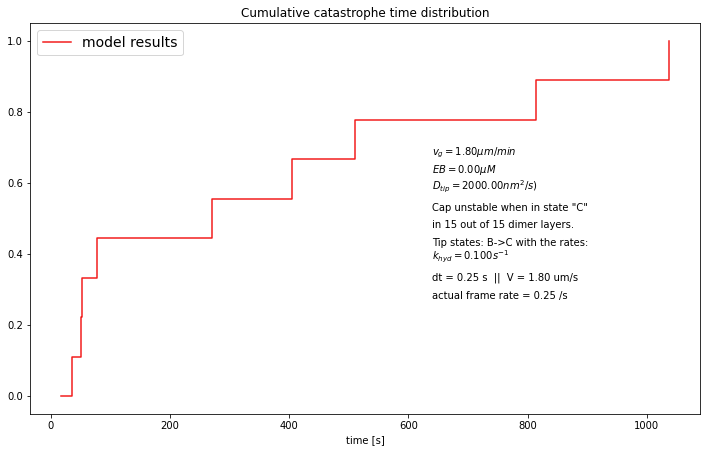

[0.65297332 0.00196116]
[[1.49966806e-02 6.66702935e-05]
 [6.66702935e-05 3.65875717e-07]]


C:\OneDrive - Netherlands eScience Center\Project_MT_simulations\mt-dynamics\mtdynamics\plotting_functions.py:1201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


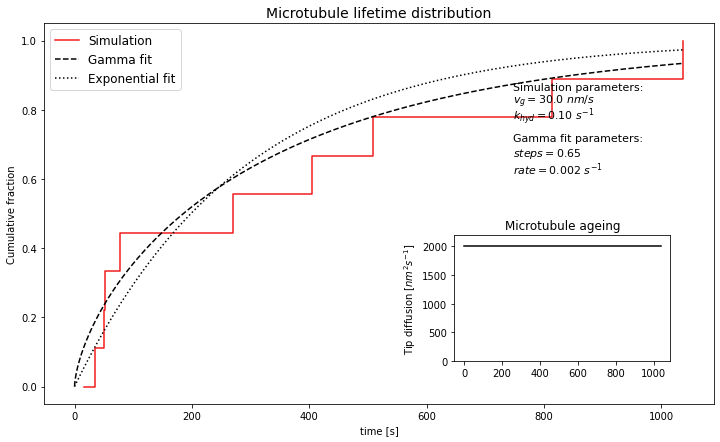

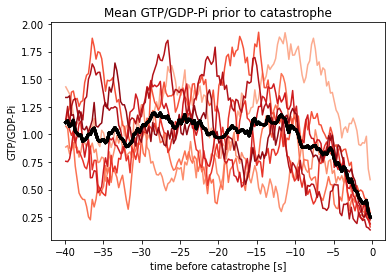

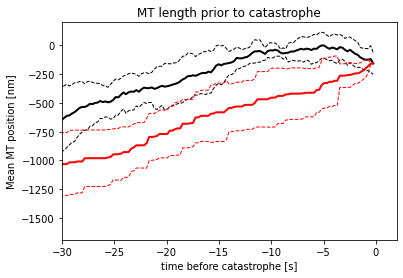

Mean shrinkage before catastrophe = 157.54 nm
Mean pause duration before catastrophe = 39.38 s


C:\OneDrive - Netherlands eScience Center\Project_MT_simulations\mt-dynamics\mtdynamics\plotting_functions.py:1059: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)


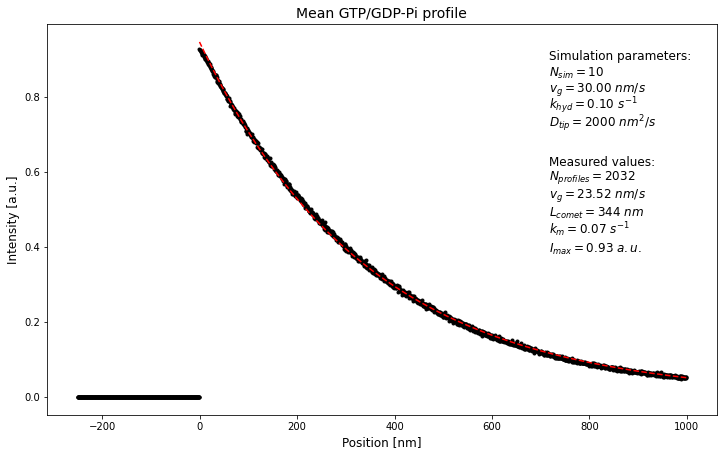

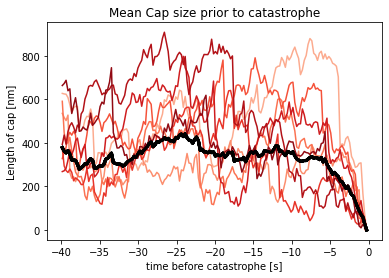

C:\OneDrive - Netherlands eScience Center\Project_MT_simulations\mt-dynamics\mtdynamics\plotting_functions.py:1114: RuntimeWarning: divide by zero encountered in true_divide
  f = (Y_dist/X_dist)/(1-Y_dist)


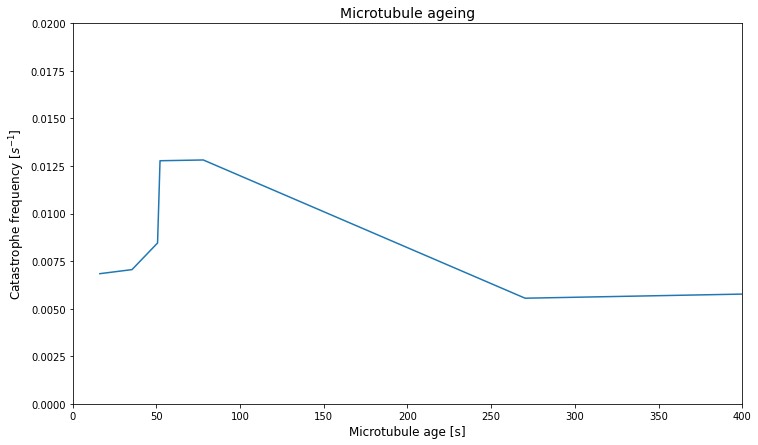

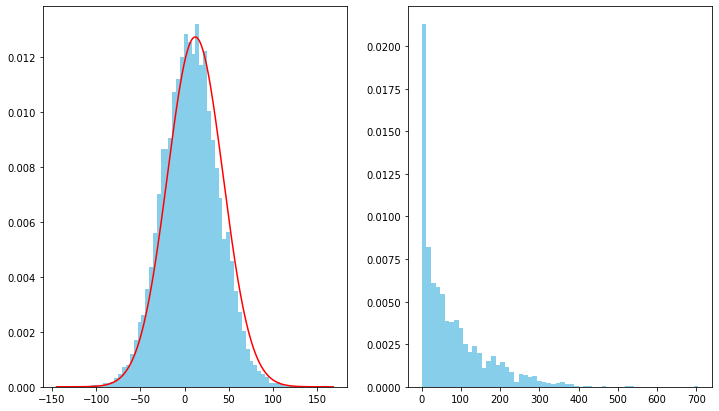

Pausing probability: 0.91
Step probability: 0.09
Mean step size: 78.9 +- 86.4 nm
Mean pausing duration: 2.63 sec 


In [21]:
if simPa.plot_figures:        

    #FIG 1,... ----- catastrophe time distribution -----------------------------   
#    if len(Cum_dist_exp) > 0:
#        plotf.fig_cat_dist(simPa, file_figure, 1, catastrophe_times, Cum_dist_exp)
            
    # FIG 2,... ----- Plot cumulative catastrophe distribution ------------------
    if len(Cum_dist_exp) > 0:
        plotf.fig_cat_cumulative(simPa, file_figure, 2, Cum_dist, Cum_dist_compare = Cum_dist_exp)
    else:
        plotf.fig_cat_cumulative(simPa, file_figure, 2, Cum_dist)
    
    # FIG 2,... ----- Plot cumulative catastrophe distribution with fits------------------
    if not simPa.washout and not simPa.barrier:
        plotf.fig_dist_fit(simPa, file_figure, 2, Cum_dist)
    
    
    # FIG 3 ----------- EB signal at barrier ------------------------------------ 
    if simPa.barrier: #if barrier present
        plotf.fig_EB_at_barrier(simPa, file_figure, 3, EB_comet_sum, barrier_contact_times)
        
     
    # FIG 4 ----------- EB signal before catastrophe ----------------------------
    if simPa.barrier: #if barrier present
        plotf.fig_EB_before_cat(simPa, file_figure, 4, EB_comet_sum, barrier_contact_times)
    else: 
        EB_bef_cat = plotf.fig_EB_before_cat(simPa, file_figure, 4, EB_comet_sum)
       
    # FIG 5 ----------- MT length before catastrophe ----------------------------
    MT_bef_cat, C_bef_cat = plotf.fig_MT_before_cat(simPa, file_figure, 5, MT_length_sum, cap_end_sum)
            
    # FIG 6 ----------- EB at catastrophe histograms ----------------------------
    if simPa.barrier:
        plotf.fig_EB_cat_hist(simPa, file_figure, 6, EB_comet_sum, 
                              barrier_contact_times, EB_average_frames = 2)   
    
    # FIG 7 ---------- EB profile during steady-state growth --------------------
    plotf.fig_EB_profile(simPa, file_figure, 7, EB_profiles, MT_length_full, w_size = 55)
  
    
    # FIG 8 ---------- Size of the cap before catastrophe -------------------- 
    if not simPa.washout and not simPa.barrier:
        plotf.fig_cap_size_before_cat(simPa,file_figure, 7, MT_length_full, cap_end)
    
    
    # FIG 9 ---------------- Microtubule ageing --------------------------------
    if not simPa.washout and not simPa.barrier:
       C_freq = plotf.fig_MT_ageing(simPa, file_figure, 9, catastrophe_times)
   
    
    # FIG 10 ---------------- Tubulin washout --------------------------------
    if simPa.washout:
        plotf.fig_washout(simPa,file_figure, 10, washout_times, catastrophe_washout, MT_length_sum) 
    
    # FIG 11 --------------- Examples of catastrophes--------------------------
#    plotf.fig_display_examples(simPa, file_figure, 11, MT_length_sum, catastrophe_times, EB_comet_sum, barrier_contact_times)  
    
    # FIG 12 ---------- Verification of simulated microtubule growth -------------
    plotf.fig_sim_verification(simPa, file_figure, 12, MT_length_full, cap_end, 1)